In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

In [4]:
# ZIP 파일 경로 및 추출 경로 설정
zip_file_path =  "/content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Test.zip"
extract_to_path = "/content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Test"

# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 해제
    zip_ref.extractall(extract_to_path)

print(f"ZIP 파일이 {extract_to_path} 경로에 성공적으로 추출되었습니다.")


ZIP 파일이 /content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Test 경로에 성공적으로 추출되었습니다.


In [5]:
# ZIP 파일 경로 및 추출 경로 설정
zip_file_path =  "/content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Validation.zip"
extract_to_path = "/content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Validation"

# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 해제
    zip_ref.extractall(extract_to_path)

print(f"ZIP 파일이 {extract_to_path} 경로에 성공적으로 추출되었습니다.")


ZIP 파일이 /content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Validation 경로에 성공적으로 추출되었습니다.


In [6]:
# ZIP 파일 경로 및 추출 경로 설정
zip_file_path =  "/content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Train.zip"
extract_to_path = "/content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Train"

# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 해제
    zip_ref.extractall(extract_to_path)

print(f"ZIP 파일이 {extract_to_path} 경로에 성공적으로 추출되었습니다.")


ZIP 파일이 /content/drive/MyDrive/LoggingDetect/MEL_Split_Data/Train 경로에 성공적으로 추출되었습니다.


In [7]:
# 데이터셋 경로
base_path = "/content/drive/MyDrive/LoggingDetect/MEL_Split_Data"
train_path = os.path.join(base_path, "Train/Train")
val_path = os.path.join(base_path, "Validation/Validation")
test_path = os.path.join(base_path, "Test/Test")

# Rainforest Connection Species Audio Detection
(BIRD DATA) 학습 모델
https://github.com/PriteshLunkad/Rainforest-Connection-Species-Audio-Detection/blob/main/Model%20Training.ipynb


In [8]:
# ! pip install --upgrade keras
# ! pip install -q tensorflow-io

import tensorflow as tf
tf.version.VERSION

'2.17.1'

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 이미지 전처리 및 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 648 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [10]:
import pandas as pd
import os
from sklearn.metrics import label_ranking_average_precision_score

from PIL import Image
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 경로 설정
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/LoggingDetect/model_bird_weights.weights.h5',  # 저장될 경로
    save_weights_only=True,  # 가중치만 저장
    save_best_only=True,     # 성능이 가장 좋은 가중치만 저장
    monitor='val_loss',      # 검증 데이터에서 val_loss가 개선되면 저장
    verbose=1                # 진행 상황을 출력
)

INPUTSHAPE = (224, 224, 3)

backbone = tf.keras.applications.DenseNet121(include_top = False,input_shape = INPUTSHAPE, weights="imagenet")

for layer in backbone.layers[:0]:
    layer.trainable = False

model_bird = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-2.))
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model_bird.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy', Recall()])

history = model_bird.fit(train_generator, validation_data=val_generator,epochs = 10, callbacks=[checkpoint_callback])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5605 - loss: 1.0478 - recall: 0.1785
Epoch 1: val_loss improved from inf to 0.72980, saving model to /content/drive/MyDrive/LoggingDetect/model_bird_weights.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 343s 8s/step - accuracy: 0.5626 - loss: 1.0422 - recall: 0.1829 - val_accuracy: 0.5050 - val_loss: 0.7298 - val_recall: 0.0100
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.7784 - loss: 0.4885 - recall: 0.6072
Epoch 2: val_loss improved from 0.72980 to 0.56954, saving model to /content/drive/MyDrive/LoggingDetect/model_bird_weights.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 994ms/step - accuracy: 0.7786 - loss: 0.4886 - recall: 0.6088 - val_accuracy: 0.6150 - val_loss: 0.5695 - val_recall: 0.2300
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8009 - loss: 0.3984 - recall: 0.7185
Epoch 3: val_loss improved from 0.56954 to 0.46340, saving model to /content/drive/MyDrive/LoggingDetect/model_bird_weights.weigh

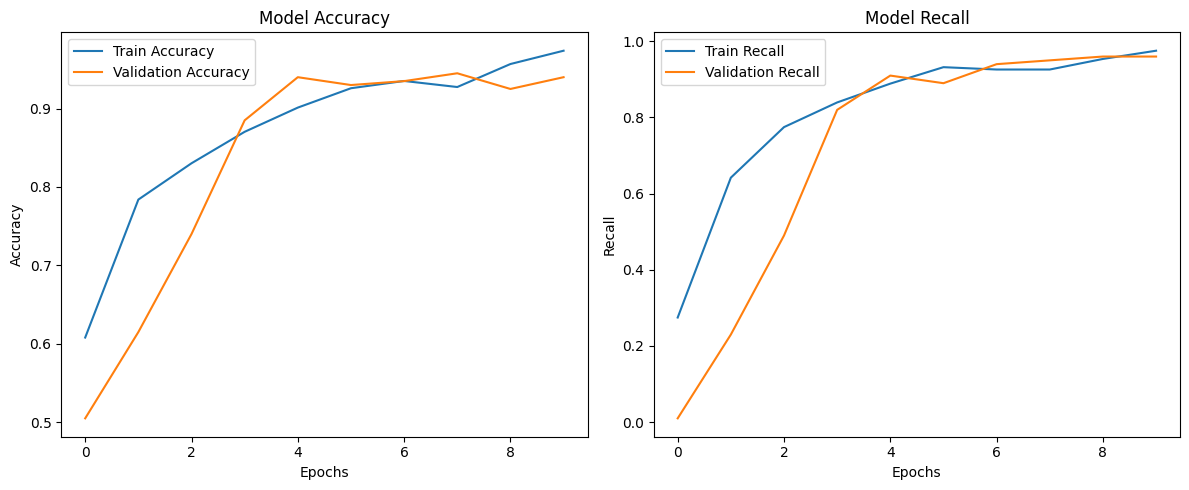

In [14]:
import matplotlib.pyplot as plt

# 학습 과정 그래프 그리기
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 그래프 출력
plot_history(history)

In [15]:
from sklearn.metrics import f1_score

# 테스트 데이터 예측
y_pred = (model_bird.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes  # 실제 라벨

# F1 스코어 계산
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
F1 Score: 0.4926


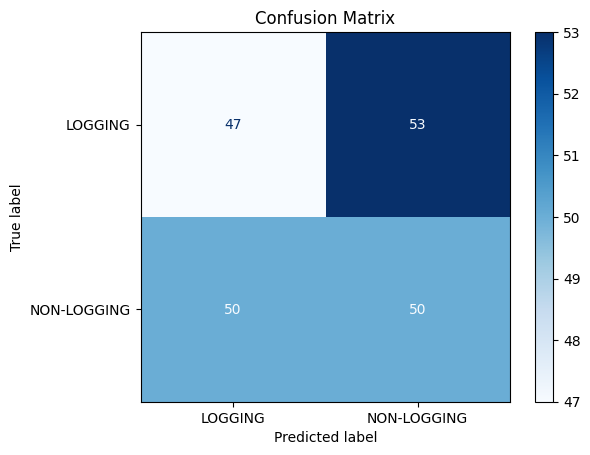

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Environmental Sound Classification 50
 (ENVIRONMENT DATA) 학습 모델
https://www.kaggle.com/code/doofensmirtz/85-validation-accuracy-tensorflow

In [39]:
from PIL import Image
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

# 모델 저장 경로 설정
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/LoggingDetect/model_esc50_weights.weights.h5',  # 저장될 경로
    save_weights_only=True,  # 가중치만 저장
    save_best_only=True,     # 성능이 가장 좋은 가중치만 저장
    monitor='val_loss',      # 검증 데이터에서 val_loss가 개선되면 저장
    verbose=1                # 진행 상황을 출력
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_accuracy',  # Metric to monitor
#     patience=5,             # Number of epochs with no improvement before stopping
#     restore_best_weights=True,  # Restore the weights of the best epoch
#     verbose=1
# )

INPUTSHAPE = (224, 224, 3)

model_esc50 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='valid', input_shape=INPUTSHAPE),
    layers.Conv2D(16, (3, 3), activation='relu', padding='valid'),

    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# 모델 컴파일
model_esc50.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy', Recall()])

history2 = model_esc50.fit(train_generator, validation_data=val_generator,epochs = 30, callbacks=[checkpoint_callback])

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.4940 - loss: 0.6936 - recall_5: 0.0239
Epoch 1: val_loss improved from inf to 0.69180, saving model to /content/drive/MyDrive/LoggingDetect/model_esc50_weights.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 904ms/step - accuracy: 0.4946 - loss: 0.6936 - recall_5: 0.0253 - val_accuracy: 0.5000 - val_loss: 0.6918 - val_recall_5: 0.0000e+00
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4624 - loss: 0.6931 - recall_5: 0.0000e+00
Epoch 2: val_loss improved from 0.69180 to 0.69019, saving model to /content/drive/MyDrive/LoggingDetect/model_esc50_weights.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 890ms/step - accuracy: 0.4641 - loss: 0.6930 - recall_5: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6902 - val_recall_5: 0.0000e+00
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5188 - loss: 0.6903 - recall_5: 0.0300
Epoch 3: val_loss improved from 0.69019 to 0.68666, saving model to /content/driv

In [41]:
# 테스트 데이터 평가
test_loss, test_accuracy, test_recall  = model_esc50.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step - accuracy: 0.7527 - loss: 0.5447 - recall_5: 0.5133
Test Accuracy: 72.00%
Test Recall: 45.00%


In [46]:
print(history2.history.keys())  # history2에서 어떤 메트릭들이 기록되었는지 확인


dict_keys(['accuracy', 'loss', 'recall_5', 'val_accuracy', 'val_loss', 'val_recall_5'])


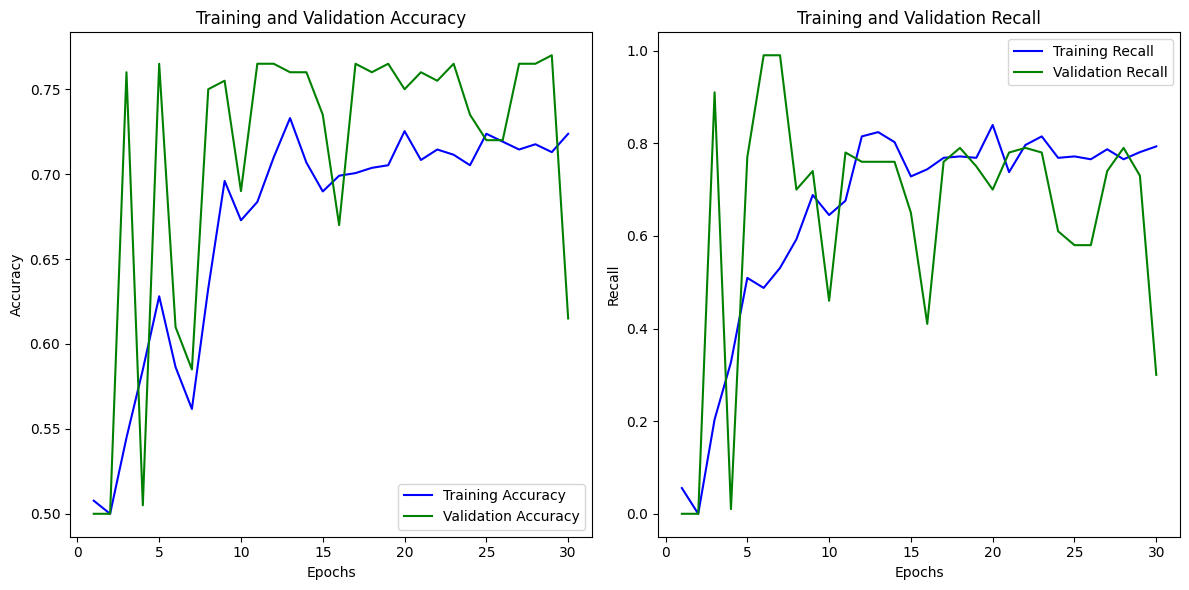

In [47]:
import matplotlib.pyplot as plt

# 학습 결과에서 정확도와 재현율 값 추출
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
recall = history2.history['recall_5']
val_recall = history2.history['val_recall_5']
epochs = range(1, len(acc) + 1)

# 정확도 그래프
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 재현율 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, recall, 'b', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
# 테스트 데이터 예측
y_pred = (model_bird.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes  # 실제 라벨

# F1 스코어 계산
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 765ms/step
F1 Score: 0.4532


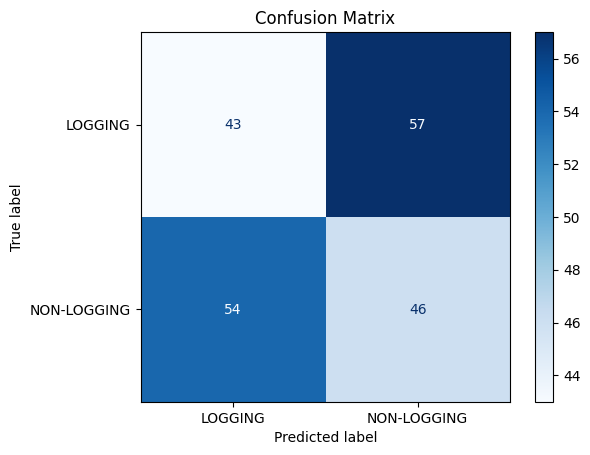

In [49]:
# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Soft Voting

In [50]:
import numpy as np
from tensorflow.keras.models import load_model

# 모델 로드 (이미 학습된 모델을 사용)
# model_bird.load_weights('/content/drive/MyDrive/LoggingDetect/model_bird_weights.weights.h5')
# model_esc50 = load_model('path_to_model_esc50')

# 예측을 위한 함수 정의
def ensemble_predict(model1, model2, X):
    # 두 모델에서 예측 결과 얻기
    preds1 = model1.predict(X)
    preds2 = model2.predict(X)

    # 확률 평균을 통한 soft voting
    avg_preds = (preds1 + preds2) / 2  # 모델별 예측을 평균내어 결합

    # 예측한 확률이 가장 큰 클래스를 선택
    final_preds = np.argmax(avg_preds, axis=1)
    return final_preds

# 예시 입력 데이터 X
# X = [test_data] # 테스트 데이터를 입력

# 앙상블 예측 결과
final_predictions = ensemble_predict(model_bird, model_esc50, test_generator)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step


In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

y_true = test_generator.classes

# 예측 결과를 사용하여 recall 계산
recall = recall_score(y_true, final_predictions, average='binary')  # 이진 분류인 경우
print(f"Ensemble Model Recall: {recall:.4f}")

accuracy = accuracy_score(y_true, final_predictions)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")


Ensemble Model Recall: 0.0000
Ensemble Model Accuracy: 0.5000


- 두번째 모델(model_esc50)이 성능이 안 좋다 보니 하나의 모델이 다른 모델을 보완하지 못 해서 최종 앙상블 예측이 유의미한 결과를 내지 못 한 듯.
- 그래서 Hard Voting으로 진행

## Hard Voting

In [52]:
import numpy as np
from tensorflow.keras.models import load_model

# 모델 로드 (이미 학습된 모델을 사용)
# model_bird.load_weights('/content/drive/MyDrive/LoggingDetect/model_bird_weights.weights.h5')
# model_esc.load_weights('/content/drive/MyDrive/LoggingDetect/model_esc50_weights.weights.h5')

# 예측을 위한 함수 정의
def hard_voting_predict(model1, model2, X):
    # 두 모델에서 예측 결과 얻기
    preds1 = model1.predict(X)
    preds2 = model2.predict(X)

    # 확률 기반 예측을 클래스(0 또는 1)로 변환
    class_preds1 = (preds1 > 0.5).astype(int)
    class_preds2 = (preds2 > 0.5).astype(int)

    # 각 클래스의 투표 결과 계산 (sum)
    final_votes = class_preds1 + class_preds2

    # Hard voting: 다수결 결정 (2명이 찬성하면 1, 그렇지 않으면 0)
    final_preds = (final_votes >= 1).astype(int)
    return final_preds

# 앙상블 예측 결과
final_predictions = hard_voting_predict(model_bird, model_esc50, test_generator)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step


In [53]:
from sklearn.metrics import accuracy_score, recall_score

# 실제 라벨 가져오기
y_true = test_generator.classes  # test_generator에서 실제 라벨 추출

# 정확도 계산
accuracy = accuracy_score(y_true, final_predictions)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# Recall 계산 (다중 클래스일 경우 'macro', 'micro', 'weighted' 선택 가능)
recall = recall_score(y_true, final_predictions, average='binary')  # 이진 분류인 경우
print(f"Ensemble Model Recall: {recall:.4f}")

Ensemble Model Accuracy: 0.4750
Ensemble Model Recall: 0.6100


In [54]:
# F1 score 계산
f1 = f1_score(y_true, final_predictions, average='binary')  # 이진 분류일 경우
print(f"Ensemble Model F1 Score: {f1:.4f}")

Ensemble Model F1 Score: 0.5374


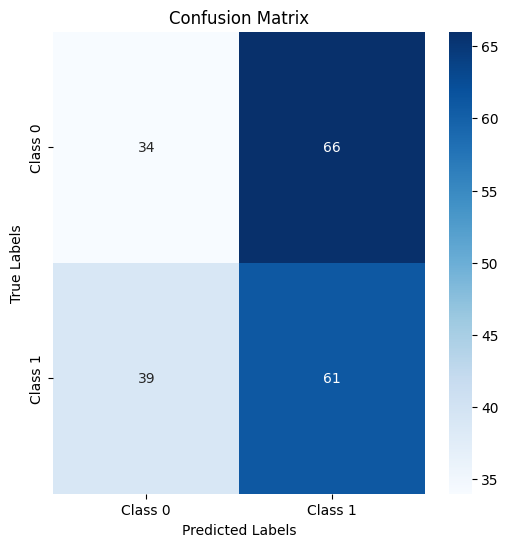

In [55]:
import seaborn as sns

# Confusion Matrix 계산
cm = confusion_matrix(y_true, final_predictions)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
